In [ ]:
CMAP = "copper"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## 目錄
#### A. 訓練方法簡介
#### B. 讀取資料
#### C. 資料整理 - 統一特徵維度，切割額外測試資料集
#### D. 特徵選取 - 以 XGBoost Model 選取特徵
#### E. 訓練模型 - 以 SVC Model 對 CCLE 資料集做分類
#### F. 輸出結果
---

## A. 訓練方法簡介
#### 手上有的資料
##### MATH5080 - 2021 Fall
* GDSC_PDX_Paclitaxel
> 399 rows x 16191 columns
* GDSC_PDX_Paclitaxel_info
> 426 rows x 5 columns
* CCLE_PDX_Paclitaxel
> 469 rows x 16383 columns

##### MATH5080 - 2020 Fall
* GDSC_2014
> 874 rows x 7964 columns
* Docetaxel_info
> 882 rows x 4 columns

---
## B. 讀取資料
### B-1 讀取 2021 data - GDSC_PDX_Paclitaxel

In [53]:
GDSC_PDX_Paclitaxel = pd.read_csv('data/GDSC_PDX_Paclitaxel.csv')
## 重新命名 Column_0 之 index
GDSC_PDX_Paclitaxel.columns.values[0] = "CELL_LINE_NAME"
# GDSC_PDX_Paclitaxel

---
### B-2 讀取 2021 data - GDSC_PDF_Paclitaxel_into，並賦予 Label 。

In [54]:
GDSC_PDX_Paclitaxel_info = pd.read_csv('data/GDSC_PDX_Paclitaxel_info.csv', index_col=0)
R_or_S_bool = np.asarray(GDSC_PDX_Paclitaxel_info["IC50"]>0.1024)
R_or_S = []
for i in range(len(R_or_S_bool)):
    if R_or_S_bool[i] == True:
        # 0 implies R, resistant
        R_or_S.append(0)
    else:
        # 1 implies S, sensitive
        R_or_S.append(1)
GDSC_PDX_Paclitaxel_info = GDSC_PDX_Paclitaxel_info.assign(R_or_S = R_or_S)
# GDSC_PDX_Paclitaxel_info

---
### B-3 讀取 2021 data - CCLE_PDX_Paclitaxel

In [55]:
CCLE_PDX_Paclitaxel = pd.read_csv('data/CCLE_PDX_Paclitaxel.csv')
## 重新命名 Column_0 之 index
CCLE_PDX_Paclitaxel.columns.values[0] = "CELL_LINE_NAME"
# CCLE_PDX_Paclitaxel

---
### B-4 讀取 2020 data - GDSC_2014

In [56]:
GDSC_2014 = pd.read_csv('old_data/GDSC_2014_Docetaxel.csv')
GDSC_2014.columns.values[0] = "CELL_LINE_NAME"
# GDSC_2014

---
### B-5 讀取 2020 data - Docetaxel_info，並賦予 Label。

In [57]:
Docetaxel_info = pd.read_csv('old_data/Docetaxel_info.csv', index_col=0)
R_or_S_bool_for_Docetaxel_info = np.asarray(Docetaxel_info["IC50"]>0.0125)
R_or_S_for_Docetaxel_info = []
for i in range(len(R_or_S_bool_for_Docetaxel_info)):
    if R_or_S_bool_for_Docetaxel_info[i] == True:
        R_or_S_for_Docetaxel_info.append(0)
    else:
        R_or_S_for_Docetaxel_info.append(1)
Docetaxel_info = Docetaxel_info.assign(R_or_S = R_or_S_for_Docetaxel_info)

# Docetaxel_info

---
## C. 資料整理
* 將 GDSC_PDF_Paclitaxel 與 GDSC_PDX_Paclitaxel_info 合併，
並以IC50數值依照給予之最大濃度給定資料集 label Resistant or Sensitive.
* 我們將使用2020的資料作為額外的 test dataset， 將 GDSC_2014 與 Docetaxel_info 合併，同樣地，
以IC50數值依照給予之最大濃度給定資料集 label Resistant or Sensitive.

----
### C-1 合併 GDSC_PDF_Paclitaxel 與 GDSC_PDX_Paclitaxel_info，新 dataframe 命名為 GDSC_combination

In [58]:
GDSC_combination = pd.merge(GDSC_PDX_Paclitaxel,
                GDSC_PDX_Paclitaxel_info,
                how='inner',
                on=['CELL_LINE_NAME'])

GDSC_combination

,CELL_LINE_NAME,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,LINC00514,OR1D5,ZNF234,MYH4,LINC00526,KRT18P55,TBC1D3P5,MAX_CONC_MICROMOLAR,IC50,R_or_S
0,MC-CAR,-1.184016,0.468235,0.485299,0.951035,0.705346,3.574280,-0.334766,-0.167187,-0.829344,...,-0.504232,0.283905,-0.785013,0.443411,0.684380,-0.006255,1.037289,0.1024,0.026059,1
1,SK-ES-1,0.949128,-0.099122,-1.142175,0.221316,0.582377,-0.500133,0.163121,-1.660569,-0.434605,...,-0.924217,-0.198564,-0.366830,-0.151292,0.246662,-0.534830,-0.214098,0.1024,0.014512,1
2,8-MG-BA,0.788220,0.840168,0.628150,-1.331285,-0.248648,-0.386293,-0.297668,0.815664,-0.212430,...,-0.376219,-0.914794,0.283323,-0.551244,-0.333331,0.038996,-0.114577,0.1024,0.005537,1
3,GB-1,0.053174,-0.648190,-0.181854,-0.633104,-0.947646,-0.469195,-0.684658,0.421926,-0.905626,...,-0.275438,-0.562004,0.634896,-0.366795,0.442662,-1.225924,0.757517,0.1024,0.040831,1
4,NCI-H1648,1.519261,-0.368292,0.226856,-0.179698,-0.865956,-0.440831,1.035865,0.896539,1.694665,...,-0.311198,-0.414697,-0.112886,-0.841901,0.379371,1.731215,-1.545600,0.1024,0.005043,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,CL-11,0.509973,0.547057,-0.601671,-0.464114,0.005193,-0.483587,-0.443398,0.765826,-0.753786,...,0.216259,-1.002894,-1.029649,0.684973,-0.045526,-0.431420,-0.068895,0.1024,1.327531,0
395,COR-L95,-0.206808,-1.340759,-0.545395,-0.429504,-0.561951,-0.619859,-0.649944,0.262877,2.319067,...,-0.736149,-1.753831,-0.127193,-0.499025,0.121546,0.148885,-0.132204,0.1024,0.188277,0
396,NCI-H2135,1.066798,0.060061,-0.570217,-0.570037,-0.342490,-0.252140,-0.148907,1.091669,2.366973,...,-0.397918,0.051392,-0.628697,0.355916,0.640426,-0.067006,1.074772,0.1024,0.109464,0
397,ME-1,-1.079919,-0.198108,0.063834,0.553150,-0.359821,-0.325923,-0.550151,0.341530,0.670671,...,-0.517000,-0.301867,1.009828,-0.353051,-1.128451,0.978038,1.259332,0.1024,0.580227,0


----
### C-2 合併 GDSC_2014 與 Docetaxel_info，新 dataframe 命名為 GDSC_2014_combination

In [59]:
GDSC_2014_combination = pd.merge(GDSC_2014, Docetaxel_info,
                                 how= 'inner',
                                 on=['CELL_LINE_NAME'])
GDSC_2014_combination

,CELL_LINE_NAME,TSPAN6,DPM1,SCYL3,FGR,CFH,GCLC,NFYA,NIPAL3,LAS1L,...,LSM14A,ZNF271,MGAM,CUX1,LINC00657,MIA,DRUG_NAME,MAX_CONC_MICROMOLAR,IC50,R_or_S
0,MC-CAR,-1.769846,0.400914,1.105859,5.273548,-0.449041,-0.834425,0.299299,-0.962201,0.326342,...,0.474520,-0.188035,0.160920,-1.582164,-2.513445,0.071012,Docetaxel,0.0125,0.007317,1
1,PFSK-1,0.588378,-0.103290,0.166505,-0.297676,2.266208,-1.103575,0.866417,-2.435215,0.165540,...,-0.278615,-1.101771,-0.543656,-0.274566,-0.605579,-0.506630,Docetaxel,0.0125,0.001761,1
2,ES5,0.823237,-0.001213,0.908039,-0.372844,0.545441,-0.368416,1.828252,0.018526,-0.803953,...,-0.086153,1.711127,-0.168805,-0.160680,1.655936,-0.375607,Docetaxel,0.0125,0.001184,1
3,ES7,0.875342,-0.407525,-0.529472,-0.432216,-0.618602,-0.127059,1.015824,-1.367511,0.162068,...,0.092430,1.350906,-0.233932,-1.343521,0.569476,-0.330056,Docetaxel,0.0125,0.000550,1
4,EW-11,0.905388,0.447038,0.063828,-0.206476,1.601144,0.054866,1.564202,-2.091522,-0.161157,...,-0.377928,1.346957,-0.370186,-1.338440,0.831166,-0.481975,Docetaxel,0.0125,0.001664,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,RCC-AB,0.496952,-0.078768,-0.204556,-0.328763,1.388162,-0.058579,0.260077,-0.371476,1.858256,...,-1.838684,1.290824,-0.278622,-1.255319,-0.885547,-0.396594,Docetaxel,0.0125,0.013015,0
846,RCC-MF,0.521452,0.070943,-1.500857,-0.383419,1.747239,0.832151,-0.686938,-1.357914,-2.077452,...,-0.095697,0.113108,-0.095794,-0.116846,0.663696,-0.458881,Docetaxel,0.0125,0.026358,0
847,KMS-11,-1.741343,0.525125,0.400613,-0.202011,-0.596353,0.150066,0.089001,1.278880,0.846353,...,0.383015,-0.176005,-0.118381,0.361427,-0.410564,-0.168539,Docetaxel,0.0125,0.034812,0
848,SNU-61,0.742257,0.039385,1.755703,-0.402440,-0.415980,0.078658,-1.293900,-0.620675,0.307138,...,-1.792592,-1.439352,0.153641,-0.430387,-0.189739,-0.245107,Docetaxel,0.0125,0.162531,0


----
### C-3 統一資料特徵維度
* 因為新資料的特徵數約在16K個左右，而舊資料約在8K個左右，
為了能用舊資料當做「額外的」測試資料集，對新舊資料的特徵數取交集。
特徵數量將會剩下 7397 個。

In [60]:
Columns_Intersection = GDSC_combination.columns.intersection(GDSC_2014_combination.columns)
reduced_GDSC_combination = GDSC_combination[Columns_Intersection]
reduced_GDSC_combination_label = reduced_GDSC_combination[["R_or_S"]]


In [61]:
reduced_GDSC_2014_combination = GDSC_2014_combination[Columns_Intersection]
reduced_GDSC_2014_combination_label = reduced_GDSC_2014_combination[["R_or_S"]]

In [62]:
Columns_Intersection_2 = CCLE_PDX_Paclitaxel.columns.intersection(reduced_GDSC_combination.columns)
reduced_CCLE_PDF_Paclitaxel = CCLE_PDX_Paclitaxel[Columns_Intersection_2]
reduced_CCLE_PDF_Paclitaxel

,CELL_LINE_NAME,AADAC,AAK1,AAMP,AANAT,AASDHPPT,AASS,AATF,AATK,ABAT,...,WSB2,WSCD2,WT1,WTAP,WWC1,WWOX,WWP1,WWP2,WWTR1,XAF1
0,22RV1_PROSTATE,-0.910305,1.059669,1.800366,0.484152,1.678559,1.231932,1.637326,0.729291,0.829308,...,1.823990,-0.910305,0.951089,1.521684,1.631582,0.964826,1.417611,1.420964,1.132964,0.036481
1,42MGBA_CENTRAL_NERVOUS_SYSTEM,0.240822,0.919266,1.698643,-0.106071,1.497530,1.068400,1.541296,0.213760,1.004570,...,1.712191,-0.065696,0.906099,1.433959,0.993361,0.841848,1.282522,1.232678,1.358025,0.804841
2,5637_URINARY_TRACT,0.604709,0.943323,1.714220,0.377315,1.578729,0.915447,1.792307,0.161015,0.384492,...,1.593100,-0.138881,1.047318,1.463047,1.570181,0.989993,1.410864,1.295599,1.239702,1.030290
3,639V_URINARY_TRACT,-0.131686,0.862144,1.718465,0.314810,1.489511,1.294921,1.670130,0.081030,0.788602,...,1.460887,-1.087801,0.983263,1.395224,1.271053,-0.164323,1.368473,1.115155,1.246357,0.580831
4,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-1.028292,0.952772,1.714692,0.024173,1.495832,0.908060,1.699985,-0.052819,0.804242,...,1.417104,-1.028292,1.236954,1.508107,0.331719,1.191023,1.335067,1.288845,0.891905,1.037151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,SKCO1_LARGE_INTESTINE,0.350356,0.845674,1.892350,0.875659,1.548170,0.014423,1.708979,1.297864,0.866179,...,1.711971,-0.889931,-0.238024,1.575199,1.546265,0.928405,1.558230,1.466095,1.266036,0.133136
465,SNU449_LIVER,1.020768,0.929154,1.911862,0.355400,1.696582,1.296588,1.855629,0.338856,0.505960,...,1.644270,-0.862985,0.035921,1.597778,1.485911,1.202976,1.637519,1.401277,1.828233,0.226257
466,T47D_BREAST,0.272479,1.075537,2.041909,0.889515,1.813404,1.085800,1.907328,0.963900,1.620551,...,1.940682,-0.001260,1.215961,1.661030,1.815180,1.379566,1.706726,1.657003,1.570593,0.354965
467,UACC257_SKIN,-0.022571,0.808529,1.804789,-0.221039,1.698608,1.270826,1.726392,1.061603,0.283742,...,1.756444,-1.018997,0.830341,1.286546,1.151934,1.152997,1.315930,1.253381,1.402175,-0.005438


In [106]:
reduced_GDSC_combination = reduced_GDSC_combination[Columns_Intersection_2]
# 把做 columns intersection 時去除的 Label 加回來。
reduced_GDSC_combination = reduced_GDSC_combination.assign(R_or_S = reduced_GDSC_combination_label)
# reduced_GDSC_combination

In [105]:
reduced_GDSC_2014_combination = reduced_GDSC_2014_combination[Columns_Intersection_2]
reduced_GDSC_2014_combination = reduced_GDSC_2014_combination.assign(R_or_S = reduced_GDSC_2014_combination_label)
# reduced_GDSC_2014_combination

----
### C-4 取舊資料對新資料的差集，作為額外測試資料集
* 舊資料有 850 種細胞珠，而新資料僅有 399 種細胞珠。
* 我使用新資料(2021)作為訓練資料集，
而去除舊資料(2020)中與新資料(2021)中重複的細胞珠作為測試資料集。
我們可以在待會發現，即便訓練資料 少於 測試資料 的情況下 (train：test = 4：5)，
我使用的訓練模型仍然達到不錯的預測結果。
* 額外測試資料集 dataframe 名稱命名為 extra_test_dataset，內有 531 個細胞珠。

In [107]:
extra_test_dataset = reduced_GDSC_2014_combination.append(reduced_GDSC_combination)
extra_test_dataset = extra_test_dataset.drop_duplicates(subset=['CELL_LINE_NAME'], keep=False)
extra_test_dataset_label = extra_test_dataset[["R_or_S"]]
extra_test_dataset_label

,R_or_S
1,1
7,1
8,1
9,1
10,1
...,...
354,0
370,0
377,0
383,0


---
## D. 特徵選取(Features Selection)

### D-1. 以 XGBoost 篩選特徵
* XGBoost 是一種 隨機森林 演算法。
* 使用 XGBoost 模型計算各個特徵的 F-score，並保留 F-score 較高的特徵（不得小於最大F-score 5%）。


列出前15個高 F-score 的特徵供參考：


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

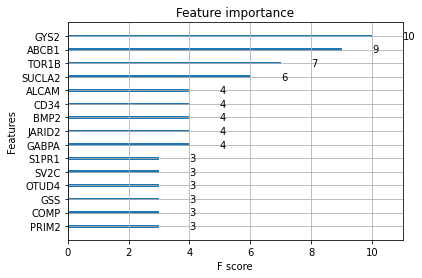

In [87]:
train_data = reduced_GDSC_combination.drop(labels=['CELL_LINE_NAME', 'R_or_S'], axis=1)
train_data_label = reduced_GDSC_combination[['R_or_S']]
XGBoost_Model = XGBClassifier()
XGBoost_Model.fit(train_data, train_data_label.values.ravel())
# print(f'Accuracy on training datset: {XGBoost_Model.score(train_data, train_data_label)}')

print(f'\n列出前15個高 F-score 的特徵供參考：')
plot_importance(XGBoost_Model, max_num_features=15)

In [102]:
feature_importances = XGBoost_Model.feature_importances_
# print(f'Features importance of AdaBoost Model: {feature_importances}')
max = np.max(feature_importances)
for i in range(len(feature_importances)):
    feature_importances[i] = feature_importances[i]/max

list_of_selected_features = []
for i in range(len(feature_importances)):
    if(feature_importances[i]>0.05):
        list_of_selected_features.append(i)

print(f'使用 XGBoost 所篩選的特徵數量： {np.array(list_of_selected_features).shape} 個')

使用 XGBoost 所篩選的特徵數量： (157,) 個


----
### D-2. 依照 XGBoost 選取的特徵，對資料的特徵做篩選

In [68]:
fs_GDSC_combination = reduced_GDSC_combination[reduced_GDSC_combination.columns[list_of_selected_features]]
fs_GDSC_combination

,AAK1,AANAT,ABCA12,ABCA8,ABCB9,ACSL3,ADCY3,ANKRD28,ANKRD7,ANXA2,...,TBCE,TFAP2A,TG,TNP1,TOR1AIP1,TPPP,TRAT1,TRIM13,UBAP2L,VSTM4
0,1.906648,0.231733,2.813247,0.637695,-0.501102,-1.534140,0.338478,0.208419,-0.073431,-0.737749,...,-1.430388,-0.491455,0.040077,-0.326072,1.178487,-1.054148,1.927292,-0.165726,-0.029658,0.345551
1,-0.518761,-0.353989,-0.180749,0.549058,-0.388767,-0.490171,-0.611932,-2.622099,3.951780,0.254189,...,0.554503,-0.687135,2.857665,0.165545,-0.802704,-0.320889,-0.201853,0.097872,1.357111,-0.637556
2,1.321418,-0.422776,-0.480170,-0.531381,0.785510,0.114270,-2.765978,0.264479,0.120262,0.951149,...,-1.033059,-0.752377,-0.054410,-0.938835,0.404184,-0.760587,-0.239611,-0.880414,0.180943,0.340385
3,0.730875,-0.296530,-0.458694,-0.770474,0.435712,-0.141656,-0.428404,2.235626,-0.669939,1.011461,...,-0.403718,-0.733698,-0.087447,-0.605880,0.022829,-0.714646,-0.279524,-0.413871,-0.971468,-1.747553
4,-1.248406,-0.206162,3.027371,-0.609428,-0.064114,-0.220128,0.481954,-0.317234,-0.746926,1.124553,...,-0.907040,0.013984,-0.452085,-0.405926,-1.431098,-0.665738,-0.263522,-0.665278,-1.858388,-1.061413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,0.533980,-0.106597,-0.226162,-0.433817,-0.285253,-1.363012,0.827192,-0.006552,-0.772947,1.011091,...,-1.706686,-0.738530,-0.431270,-0.298217,-0.091488,-0.731939,-0.180040,-0.794680,-0.586292,-0.785630
395,-1.152426,-0.779573,0.229263,-0.871816,-0.954654,-0.088226,-0.131277,-0.270070,-0.845781,-1.645165,...,-2.965395,-0.829874,-0.515783,-0.407248,-0.144628,0.697741,-0.408224,-2.478160,0.017733,-0.412977
396,0.497909,-0.013291,-0.224135,0.208550,0.898023,-0.023965,0.534647,-0.715295,-0.130239,0.741091,...,1.108938,-0.330397,-0.209784,0.613250,0.857054,-0.132528,-0.083345,-0.799773,0.565049,-0.215327
397,-0.486149,0.123253,-0.166654,-0.074542,-0.158834,-4.091931,1.715548,0.044058,-0.282445,-2.113900,...,-0.208406,-0.215968,0.211222,2.027927,0.795323,-0.450778,-0.284392,1.654560,0.489153,0.768470


In [103]:
fs_extra_test_dataset = extra_test_dataset[extra_test_dataset.columns[list_of_selected_features]]
# fs_extra_test_dataset

In [104]:
fs_CCLE_PDF_Paclitaxel = reduced_CCLE_PDF_Paclitaxel[reduced_CCLE_PDF_Paclitaxel.columns[list_of_selected_features]]
# fs_CCLE_PDF_Paclitaxel

----
## E. 訓練模型
* 篩選特徵後，使用不同模型重新訓練，並觀察其在 額外測試資料集 上的結果

### E-1. 使用 SVM 訓練

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


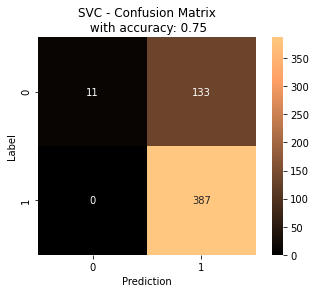

In [71]:
SVC_Model = SVC()
SVC_Model.fit(fs_GDSC_combination, reduced_GDSC_combination_label)
SVC_result = SVC_Model.predict(fs_extra_test_dataset)
SVC_score = SVC_Model.score(fs_extra_test_dataset, extra_test_dataset_label)
SVC_score = np.around(SVC_score, decimals=3)

SVC_cm = confusion_matrix(extra_test_dataset_label, SVC_result)
sns.heatmap(SVC_cm, square=True, annot=True, cmap=CMAP, cbar=True, fmt="")
SVC_plot = plt.xlabel("Prediction")
SVC_plot = plt.ylabel("Label")
SVC_plot = plt.title(f"SVC - Confusion Matrix\n with accuracy: {SVC_score}")

plt.show(SVC_plot)

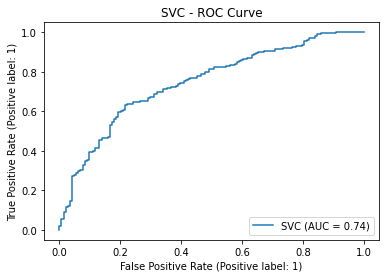

In [72]:
metrics.plot_roc_curve(SVC_Model, fs_extra_test_dataset, extra_test_dataset_label)
plt.title("SVC - ROC Curve")
plt.show()

----
### E-2. 使用 Adaboost 訓練


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


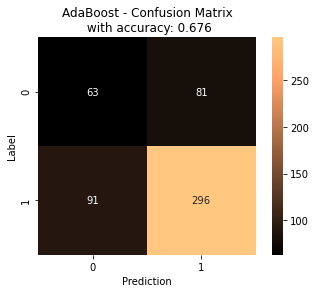

In [73]:
AdaBoost_Model = AdaBoostClassifier()
AdaBoost_Model.fit(fs_GDSC_combination, reduced_GDSC_combination_label)
AdaBoost_result = AdaBoost_Model.predict(fs_extra_test_dataset)
AdaBoost_score = AdaBoost_Model.score(fs_extra_test_dataset, extra_test_dataset_label)
AdaBoost_score = np.around(AdaBoost_score, decimals=3)

AdaBoost_cm = confusion_matrix(extra_test_dataset_label, AdaBoost_result)
sns.heatmap(AdaBoost_cm, square=True, annot=True, cmap=CMAP, cbar=True, fmt="")
AdaBoost_plot = plt.xlabel("Prediction")
AdaBoost_plot = plt.ylabel("Label")
AdaBoost_plot = plt.title(f"AdaBoost - Confusion Matrix\n with accuracy: {AdaBoost_score}")
plt.show(AdaBoost_plot)

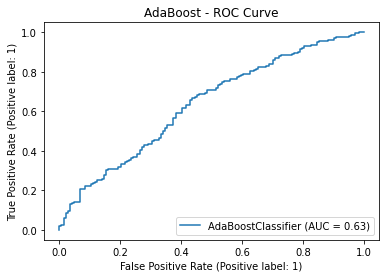

In [74]:
metrics.plot_roc_curve(AdaBoost_Model, fs_extra_test_dataset, extra_test_dataset_label)
plt.title("AdaBoost - ROC Curve")
plt.show()

----
### E-3. 使用 KNN 訓練

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


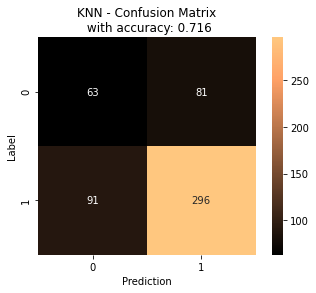

In [75]:
KNN_Model = KNeighborsClassifier(n_neighbors=3)

KNN_Model.fit(fs_GDSC_combination, reduced_GDSC_combination_label)
KNN_result = KNN_Model.predict(fs_extra_test_dataset)
KNN_score = KNN_Model.score(fs_extra_test_dataset, extra_test_dataset_label)
KNN_score = np.around(KNN_score, decimals=3)
KNN_cm = confusion_matrix(extra_test_dataset_label, KNN_result)
sns.heatmap(AdaBoost_cm, square=True, annot=True, cmap=CMAP, cbar=True, fmt="")
KNN_plot = plt.xlabel("Prediction")
KNN_plot = plt.ylabel("Label")
KNN_plot = plt.title(f"KNN - Confusion Matrix\n with accuracy: {KNN_score}")

plt.show(KNN_plot)

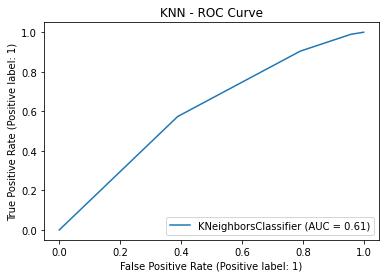

In [76]:
metrics.plot_roc_curve(KNN_Model, fs_extra_test_dataset, extra_test_dataset_label)
plt.title("KNN - ROC Curve")
plt.show()

----
### E-4. 使用 Gaussian Naive Bayes 訓練

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


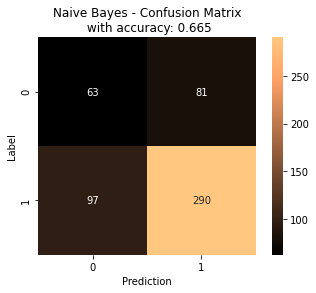

In [77]:
NB_Model = GaussianNB()

NB_Model.fit(fs_GDSC_combination, reduced_GDSC_combination_label)
NB_score = NB_Model.score(fs_extra_test_dataset, extra_test_dataset_label)
NB_score = np.around(NB_score, decimals=3)
NB_result = NB_Model.predict(fs_extra_test_dataset)

NB_cm = confusion_matrix(extra_test_dataset_label, NB_result)
sns.heatmap(NB_cm, square=True, annot=True, cmap=CMAP, cbar=True, fmt="")
NB_plot = plt.xlabel("Prediction")
NB_plot = plt.ylabel("Label")
NB_plot = plt.title(f"Naive Bayes - Confusion Matrix\n with accuracy: {NB_score}")
plt.show(NB_plot)

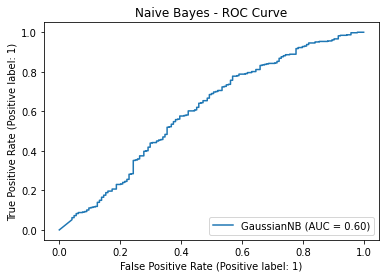

In [78]:
NB_ROC = metrics.plot_roc_curve(NB_Model, fs_extra_test_dataset, extra_test_dataset_label)
plt.title("Naive Bayes - ROC Curve")
plt.show(NB_ROC)

---
## F. 輸出結果 - 選定SVC模型做預測
* 上述四個模型中，SVC表現最好，我們使用此模型來輸出 CCLE_PDX_Paclitaxel 的預測值。

----
### F-1. K-fold 交叉驗證
* 將 k 設為 5，做交叉驗證，測試模型性能。

In [80]:
kfold = KFold(n_splits=5, shuffle=True)
kfold_results = cross_val_score(SVC_Model, fs_GDSC_combination,
                                reduced_GDSC_combination_label.values.ravel(),
                                cv=kfold)
print(kfold_results)

[0.75  0.713 0.812 0.7   0.709]


----
### F-2 對 CCLE 中細胞珠進行預測（分類）

In [97]:
CCLE_result = SVC_Model.predict(fs_CCLE_PDF_Paclitaxel)
Label = []
for i in range(len(CCLE_result)):
    if CCLE_result[i] == 0:
        Label.append("R")
    else:
        Label.append("S")
CCLE_PDX_Paclitaxel_result = CCLE_PDX_Paclitaxel.assign(Label = Label)
CCLE_PDX_Paclitaxel_result = CCLE_PDX_Paclitaxel_result[["CELL_LINE_NAME", "Label"]]
CCLE_PDX_Paclitaxel_result_pure_label = CCLE_PDX_Paclitaxel_result[["Label"]]
CCLE_PDX_Paclitaxel_result

,CELL_LINE_NAME,Label
0,22RV1_PROSTATE,S
1,42MGBA_CENTRAL_NERVOUS_SYSTEM,S
2,5637_URINARY_TRACT,S
3,639V_URINARY_TRACT,S
4,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,S
...,...,...
464,SKCO1_LARGE_INTESTINE,S
465,SNU449_LIVER,S
466,T47D_BREAST,S
467,UACC257_SKIN,S


----

### F-3 將結果輸出為 CSV file
* 我分別輸出兩個 CSV 檔案，一個檔案包含 細胞珠名稱 與對應的 R/S 分類結果；另一個檔案中則僅有 分類結果，方便事後核對。

In [101]:
CCLE_PDX_Paclitaxel_result.to_csv("classification_result/result_with_header_and_index.csv")
CCLE_PDX_Paclitaxel_result_pure_label.to_csv("classification_result/pure_label.csv", index=False, header=None)